# Homework 4: More Principal Component Analysis
***
This homework focuses on familiarizing you with low-rank approximations and multi-dimensional scaling. In addition, you will work with the CIFAR-10 dataset, a popular benchmark dataset for most classification algorithms.

# Load data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
def showImage(pixels, label):
    pixels = np.reshape(pixels,(3,1024))
    pixels = np.transpose(pixels)
    pixels = np.reshape(pixels,(32,32,3))
    plt.title(label)
    plt.imshow(pixels)
    plt.show()

In [49]:
def getPCA(data, n_components):
    pca = PCA(n_components)
    pca.fit(data)
    return pca.transform(data)

In [37]:
def aggregateByCategory(data, labels): 
    imageByCategory = {}
    for index in range(len(data)):
        label = labels[index]
        if(label not in imageByCategory):
            imageByCategory[label] = []
        imageByCategory[label].append(data[index])
    return imageByCategory

In [52]:
def getPCAForImages(images):
    categoryPCA = {}
    for category in imagesByCategory:
        images = np.array(imagesByCategory[category])
        categoryPCA[category] = getPCA(images, 20)
    return categoryPCA

In [25]:
data_batch1 = unpickle('data/data_batch_1')
data_batch2 = unpickle('data/data_batch_2')
data_batch3 = unpickle('data/data_batch_3')
data_batch4 = unpickle('data/data_batch_4')
data_batch5 = unpickle('data/data_batch_5')
test_batch = unpickle('data/test_batch')

In [26]:
combined_data = np.concatenate((data_batch1[b'data'], data_batch2[b'data'], data_batch3[b'data'], data_batch4[b'data'], data_batch5[b'data'], test_batch[b'data']))
combined_labels = np.concatenate((data_batch1[b'labels'], data_batch2[b'labels'], data_batch3[b'labels'], data_batch4[b'labels'], data_batch5[b'labels'], test_batch[b'labels']))
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_of_items = len(combined_data)

# Part A

In [19]:
mean_images = np.zeros((10, 3072))

for i in range(num_of_items):
    mean_images[combined_labels[i]] = mean_images[combined_labels[i]] + combined_data[i]

mean_images = mean_images / 6000
mean_images = mean_images.astype('uint8')  

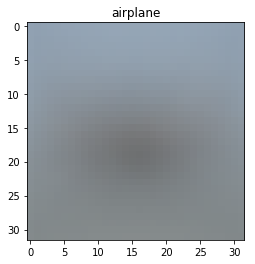

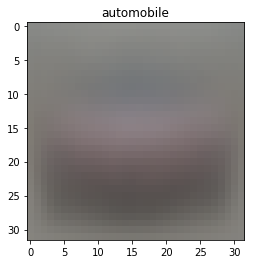

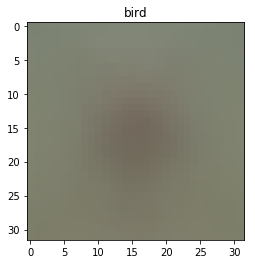

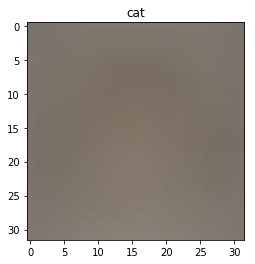

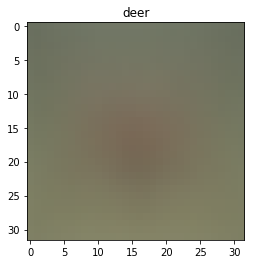

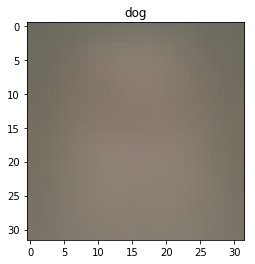

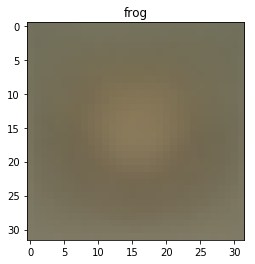

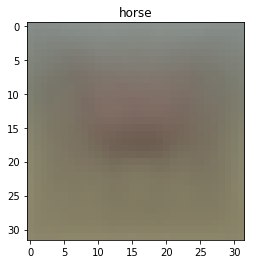

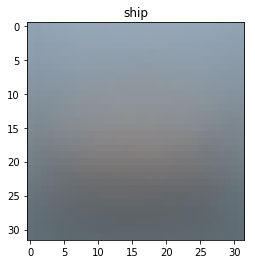

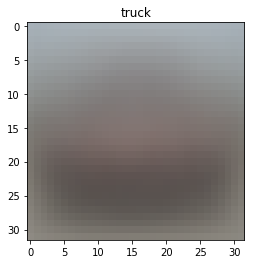

In [20]:
for i in range(len(label_names)):
    showImage(mean_images[i], label_names[i])

## PCA first 20 principal components

In [38]:
imagesByCategory = aggregateByCategory(combined_data, combined_labels)

In [56]:
pcaByImageCategory = getPCAForImages(imagesByCategory)